# Random Forest untuk Prediksi Time Series

- Muat data dan pra-pemrosesan
- Bentuk fitur lag dan rolling
- Split train/valid/test secara time-aware
- Latih RandomForest, evaluasi (MAE, RMSE, MAPE) dan plot
- Hyperparameter tuning (TimeSeriesSplit + RandomizedSearchCV)
- Walk-forward evaluation
- Feature importance dan simpan model

In [19]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.style.use("seaborn-v0_8")
pd.options.display.max_columns = 100

In [20]:

# Nama file Excel asli Anda
file_excel_asli = "Padi Kebumen.xlsx"

# Membaca sheet 'Luas Panen (Ha)' dari file Excel
df_hasil = pd.read_excel(file_excel_asli, sheet_name="Padi")

In [21]:
df_hasil

,NO,TAHUN,HASIL PRODUKSI PADI/PERTAHUN
0,1,1986,292374.00
1,2,1987,267675.00
2,3,1988,300424.00
3,4,1989,345635.00
4,5,1990,348303.00
5,6,1991,353877.00
6,7,1992,382249.00
7,8,1993,367377.00
8,9,1994,361633.00
9,10,1995,369800.00


In [22]:
# Buang kolom 'NO'
df_hasil = df_hasil.drop(columns=['NO'])

# Ganti nama kolom agar lebih pendek dan mudah
df_hasil = df_hasil.rename(columns={
    'TAHUN': 'Tahun',
    'HASIL PRODUKSI PADI/PERTAHUN': 'Produksi'
})

# Atur 'Tahun' sebagai index (ini memudahkan proses time series)
df_hasil = df_hasil.set_index('Tahun')

print("Data setelah dibersihkan:")
print(df_hasil.head())

Data setelah dibersihkan:
       Produksi
Tahun          
1986   292374.0
1987   267675.0
1988   300424.0
1989   345635.0
1990   348303.0


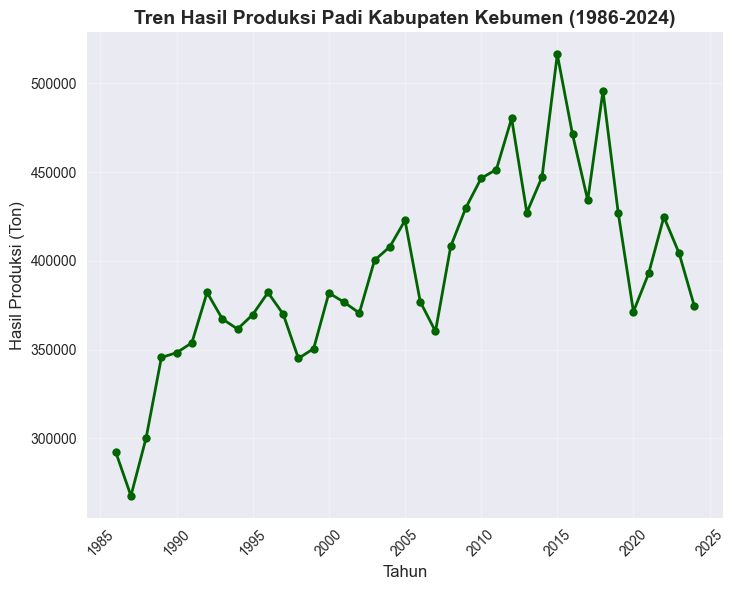

In [23]:
# Plot data hasil produksi padi per tahun
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(
    df_hasil['Produksi'], 
    marker='o', 
    linewidth=2, 
    markersize=6, 
    color='darkgreen')
plt.title('Tren Hasil Produksi Padi Kabupaten Kebumen (1986-2024)', 
          fontsize=14, 
          fontweight='bold')
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Hasil Produksi (Ton)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [24]:
df_hasil.dtypes

Produksi    float64
dtype: object

In [25]:
# Membuat fitur lag (data 1 tahun lalu)
# df['Produksi'].shift(1) berarti "ambil data produksi, geser 1 baris ke bawah"
df_hasil['Produksi_Lag_1'] = df_hasil['Produksi'].shift(1)

# Membuat fitur lag (data 2 tahun lalu)
df_hasil['Produksi_Lag_2'] = df_hasil['Produksi'].shift(2)

# Membuat fitur rolling average 3 tahun
# Ini adalah rata-rata produksi 3 tahun terakhir (N-1, N-2, N-3)
df_hasil['Produksi_Roll_Avg_3'] = df_hasil['Produksi'].shift(1).rolling(window=3).mean()

# Kita juga bisa gunakan 'Tahun' sebagai fitur numerik
df_hasil['Tahun_Feature'] = df_hasil.index

# Buang baris yang punya nilai NaN (Not a Number)
# Ini adalah baris-baris pertama (1986, 1987, 1988) yang tidak punya data lag lengkap
df_clean = df_hasil.dropna()

print("\nData setelah Feature Engineering:")
print(df_clean.head())


Data setelah Feature Engineering:
       Produksi  Produksi_Lag_1  Produksi_Lag_2  Produksi_Roll_Avg_3  \
Tahun                                                                  
1989   345635.0        300424.0        267675.0        286824.333333   
1990   348303.0        345635.0        300424.0        304578.000000   
1991   353877.0        348303.0        345635.0        331454.000000   
1992   382249.0        353877.0        348303.0        349271.666667   
1993   367377.0        382249.0        353877.0        361476.333333   

       Tahun_Feature  
Tahun                 
1989            1989  
1990            1990  
1991            1991  
1992            1992  
1993            1993  


In [26]:
df_clean

,Produksi,Produksi_Lag_1,Produksi_Lag_2,Produksi_Roll_Avg_3,Tahun_Feature
Tahun,,,,,
1989,345635.00,300424.00,267675.00,286824.333333,1989
1990,348303.00,345635.00,300424.00,304578.000000,1990
1991,353877.00,348303.00,345635.00,331454.000000,1991
1992,382249.00,353877.00,348303.00,349271.666667,1992
1993,367377.00,382249.00,353877.00,361476.333333,1993
1994,361633.00,367377.00,382249.00,367834.333333,1994
1995,369800.00,361633.00,367377.00,370419.666667,1995
1996,382229.00,369800.00,361633.00,366270.000000,1996
1997,370019.00,382229.00,369800.00,371220.666667,1997


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Impor model-model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Impor alat bantu
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [22]:
from sklearn.model_selection import train_test_split

# Definisikan X (fitur) dan y (target)
# Fitur kita adalah 'Tahun' dan data-data historis
X = df_clean[['Tahun_Feature', 'Produksi_Lag_1', 'Produksi_Lag_2', 'Produksi_Roll_Avg_3']]
y = df_clean['Produksi']

# Membagi data. 80% untuk latih, 20% untuk uji.
# PENTING: shuffle=False untuk time series!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Data Latih (Train): {X_train.shape[0]} baris (Tahun {X_train.index.min()} - {X_train.index.max()})")
print(f"Data Uji (Test): {X_test.shape[0]} baris (Tahun {X_test.index.min()} - {X_test.index.max()})")

Data Latih (Train): 28 baris (Tahun 1989 - 2016)
Data Uji (Test): 8 baris (Tahun 2017 - 2024)


In [23]:
# 1. Buat alat scaler
scaler = StandardScaler()

# 2. Pelajari skala dari X_train dan langsung transformasikan
X_train_scaled = scaler.fit_transform(X_train)

# 3. Transform X_test menggunakan skala yang SUDAH DIPELAJARI dari X_train
X_test_scaled = scaler.transform(X_test)

print("Data berhasil di-scaling.")
print(f"Bentuk X_train_scaled: {X_train_scaled.shape}")
print(f"Bentuk X_test_scaled: {X_test_scaled.shape}")

Data berhasil di-scaling.
Bentuk X_train_scaled: (28, 4)
Bentuk X_test_scaled: (8, 4)


In [24]:

# --- 1. Linear Regression (pakai data scaled) ---
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
print("Model Linear Regression selesai dilatih.")

# --- 2. Random Forest (tidak perlu data scaled) ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train) # RF tidak wajib scaled
print("Model Random Forest selesai dilatih.")

# --- 3. Support Vector Regressor (WAJIB data scaled) ---
svr_model = SVR(kernel='rbf', C=1.0) # Kernel 'rbf' adalah pilihan umum yang baik
svr_model.fit(X_train_scaled, y_train)
print("Model SVR selesai dilatih.")

Model Linear Regression selesai dilatih.
Model Random Forest selesai dilatih.
Model SVR selesai dilatih.


In [25]:
# Buat list untuk menyimpan hasil
results = []

# --- 1. Prediksi & Evaluasi Linear Regression ---
y_pred_lr = lr_model.predict(X_test_scaled)
results.append({
    'Model': 'Linear Regression',
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    'R2': r2_score(y_test, y_pred_lr),
    'MAE': mean_absolute_error(y_test, y_pred_lr)
})

# --- 2. Prediksi & Evaluasi Random Forest ---
y_pred_rf = rf_model.predict(X_test) # Prediksi pakai X_test asli
results.append({
    'Model': 'Random Forest',
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'R2': r2_score(y_test, y_pred_rf),
    'MAE': mean_absolute_error(y_test, y_pred_rf)
})

# --- 3. Prediksi & Evaluasi SVR ---
y_pred_svr = svr_model.predict(X_test_scaled)
results.append({
    'Model': 'SVR',
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_svr)),
    'R2': r2_score(y_test, y_pred_svr),
    'MAE': mean_absolute_error(y_test, y_pred_svr)
})

# Ubah hasil menjadi DataFrame Pandas
df_results = pd.DataFrame(results)

# Tampilkan tabel perbandingan
print("\n--- Perbandingan Metrik Model ---")
# Urutkan berdasarkan RMSE (terkecil ke terbesar)
print(df_results.sort_values(by='RMSE'))


--- Perbandingan Metrik Model ---
               Model          RMSE        R2           MAE
2                SVR  50338.054602 -0.799072  38111.358215
0  Linear Regression  59476.668314 -1.511591  54990.989442
1      Random Forest  61072.177119 -1.648149  55267.086525



Plot 'perbandingan_model_time_series.png' berhasil disimpan.


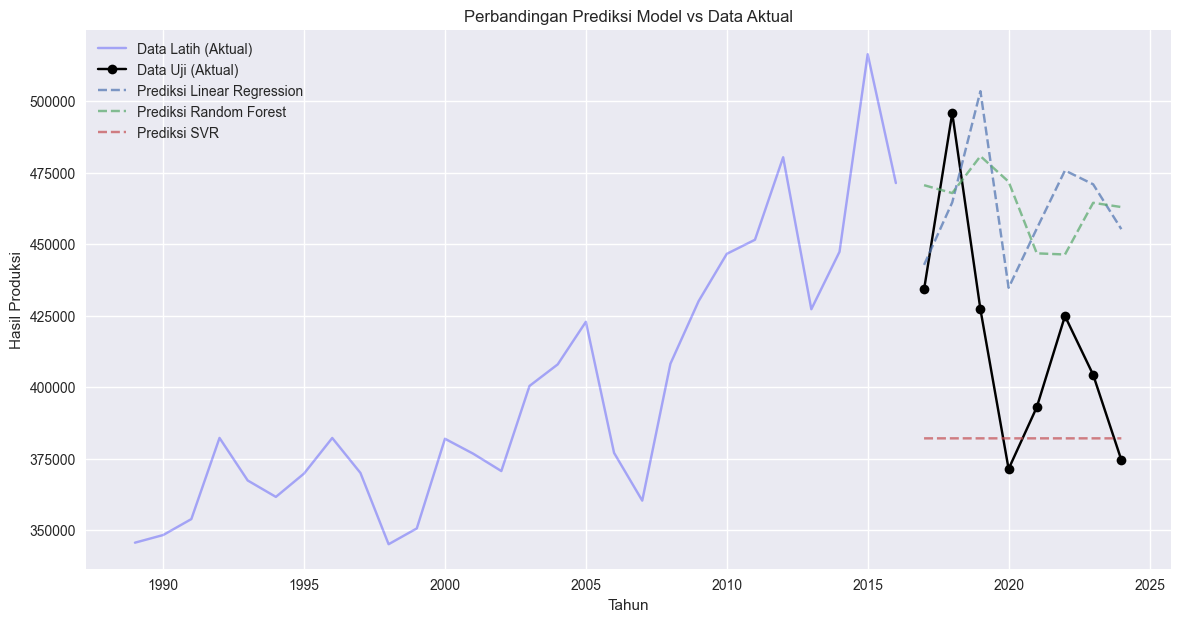

In [26]:
plt.figure(figsize=(14, 7))

# Plot data aktual (latih dan uji)
plt.plot(y_train.index, y_train, label='Data Latih (Aktual)', color='blue', alpha=0.3)
plt.plot(y_test.index, y_test, label='Data Uji (Aktual)', color='black', marker='o', linestyle='-')

# Plot prediksi dari semua model
plt.plot(y_test.index, y_pred_lr, label='Prediksi Linear Regression', linestyle='--', alpha=0.7)
plt.plot(y_test.index, y_pred_rf, label='Prediksi Random Forest', linestyle='--', alpha=0.7)
plt.plot(y_test.index, y_pred_svr, label='Prediksi SVR', linestyle='--', alpha=0.7)

plt.title("Perbandingan Prediksi Model vs Data Aktual")
plt.xlabel("Tahun")
plt.ylabel("Hasil Produksi")
plt.legend()
plt.grid(True)
plt.savefig('perbandingan_model_time_series.png')

print("\nPlot 'perbandingan_model_time_series.png' berhasil disimpan.")